Death Star standard gravity ('g') estimation and error propagation, using Markov Chain Monte Carlo.
------

In [224]:
# Code was created by Dave Quint @ LLNL AEED Computational Geosciences.
# Comments or Questions email: quint2@llnl.gov

# Useful python modules 
import numpy as np
import pandas as pd
from scipy import optimize, stats, integrate
import matplotlib.pyplot as plt
rng = np.random.RandomState(314) # use the same seed for reproducibility 

In [225]:
# read the Death Star projectile experiment data
df = pd.read_csv('range_data_exp.csv')

# Our measureables and associated error
alphaMeas = df['alpha'] # list of shot angles 
rObs = df['rObs'] # measured observables
rErr = df['rErr'] # measurement errors

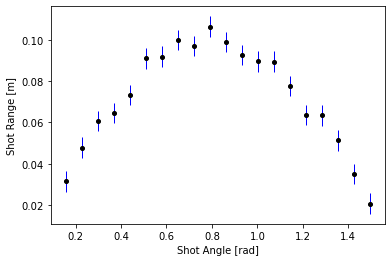

In [226]:
# plot the observable range data (and error) over all shot angles
plt.figure(1)
plt.errorbar(alphaMeas, rObs, yerr=rErr, lw=0, elinewidth=1, ecolor='b', fmt='ko', markersize=4)
plt.xlabel('Shot Angle [rad]')
plt.ylabel('Shot Range [m]');

In [227]:
#Emperical model for the projectile range
def modelFit(alpha, g):
    v0=1. # initial speed is always = 1 m/s
    r = (v0 ** 2) * np.sin(2.*alpha)/g
    return r

Optimal g = 9.77626[m/s^2]


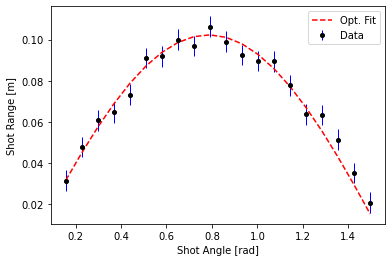

In [228]:
#Least squares fit of the data

g0 = 9.80665 # [m]/[s^2]: OG-g [Nominal value of standard gravity on Tatooine]
gOp, aCova = optimize.curve_fit(modelFit, alphaMeas, rObs, g0)

# plot the experiment data and the optimal fit curve
plt.figure(2)
plt.errorbar(alphaMeas, rObs, yerr=rErr, lw=0, elinewidth=1, ecolor='b', fmt='ko', markersize=4)
plt.plot(alphaMeas, modelFit(alphaMeas, *gOp),'--r')
plt.xlabel('Shot Angle [rad]')
plt.ylabel('Shot Range [m]')
plt.legend(['Opt. Fit','Data'])
print('Optimal g = {0:.5f}[m/s^2]'.format(gOp[0]));

First, we will use Monte Carlo combined with least squares optimization to sample the distribution for 'g'. 
-----------------------------------
1).We assume that any new realization of our experiment will produce a new set of measureables.

2). We also assume that an ensemble of measurements at each shot angle, will follow a normal distribution. Where the mean of the ensemble is the orginal observation at a particular shot angle and the variance is the observation error. This assumption is the Monte Carlo sampling step. 

                        y_trial = y_obs + Normal(0,sigma_obs)

3). After generating a new set of trial measurments using the step above, we then repeat the least-sqaures optimization on the new set of observables. The target distribution we wish to sample is the distribution for 'g'. 

4). Upon a sucessful least-squares fit we collect the optimal value of 'g' and add it to the ensemble. 

In [229]:
# Monte Carlo sampling with least-squares optimization. 
#------------------------------------------------------#

nTrials = 2000 # Number of total trial sets of data we will generate
fails = 0 # keeps track of the failure for fitting (if any)
gAcceptMC = np.array([]) # A place to store our "accepted" optimal values of 'g'
grng =gOp[0]
# loop over all trials
for iTrial in range(nTrials):
    # Generate new trial set of observables
    rTrial = rObs + rng.normal(scale=rErr, size=np.size(rObs)) # normal distribution
# We will try fitting, as some fit may fail
    try:
        # fit the new trial data
        gTrial, aCova = optimize.curve_fit(modelFit, alphaMeas, rTrial, grng)        
    except:
        # this catches failed fits but does not exit the loop when that happens
        fails = fails + 1 
        continue
        
    if np.size(gAcceptMC) < 1: # first time we store fit params
        gAcceptMC=np.copy(gTrial)
    else:
        gAcceptMC = np.concatenate((gAcceptMC, gTrial)) # append accepted array

In [230]:
len(gAcceptMC)

2000

The mean value of the g ensemble using MC-Opt is: = 9.77385[m/s^2]
The optimal g found with fitting was: = 9.77626[m/s^2]
The % difference is : = 0.02470%


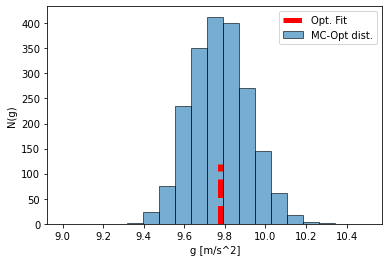

In [231]:
#%% Plot the histogram of optimal 'g' values
plt.figure(3)
plt.hist(gAcceptMC, bins=np.linspace(9.0,10.5,20), edgecolor='k', alpha=0.6)
plt.ylabel('N(g)')
plt.xlabel('g [m/s^2]')
plt.plot(gOp[0]*np.ones(10), np.linspace(0,120,10),'--r', lw=5);
plt.legend(['Opt. Fit','MC-Opt dist.'])
print('The mean value of the g ensemble using MC-Opt is: = {0:.5f}[m/s^2]'.format(np.mean(gAcceptMC)))
print('The optimal g found with fitting was: = {0:.5f}[m/s^2]'.format(gOp[0]))
print('The % difference is : = {0:.5f}%'.format(np.abs( 100*(1.-np.mean(gAcceptMC)/gOp[0]) )));

Now we will use Markov-Chain Monte Carlo (MCMC) to sample the distribution for 'g'. 
----------------------

1). We first define the likelihood of observing the data, given the value of 'g'. 
                        
                        P(D|g) = normal distribution
2). We loop over many interations rach time picking a new trial value for 'g'. Evaluating the emperical model assuming that value of 'g', then compare that to the observed data. 

3). We take the new likelihood computed from the comparison of the observed data and the model, and compare that to the previous value of the likelihood. (This is the acceptance probability)

4). Then we perform the Metropolis-Hastings step. Comapring the acceptance value to a random number drawn from a uniform distribution.

5). IF the acceptance is greater than the random number, we accept that trial value of 'g', and keep the value for the likelihood for the next step. If it is less than 1, we only accept the value of 'g' if the random number is less than the acceptance probability.


In [232]:
# The likelihood function for computing the acceptance probability

def likelihood(rObs, rGuess, rErr):
    llh = np.sqrt(1/(2*np.pi*np.power(rErr,2)))*np.exp(-np.power(0.5*(rObs-rGuess)/rErr,2))
    return np.prod(llh)

In [233]:
# Setting up the MCMC sampler
burnIn = 1000 # Burn-in to get the sampler close to the 'True' value of 'g'
nTrials = 3000 # Number of total MCMC trials : [final sample size = nTrials - burnIn]
#gBounds = [8, 11] # sampling bounds for 'g'
gBounds = [0.66*gOp[0], 1.33*gOp[0]] # sampling bounds for 'g'
gGuess0 = gOp[0]#at the optimal vaule
rGuess0 = modelFit(alphaMeas,gGuess0)
llh0 = likelihood(rObs, rGuess0, rErr) # initialize MCMC 

In [234]:
gAcceptMCMC = list() # A place to store our accepted values of 'g'

# The MCMC Metropolis-Hastings Loop
n=0
while n < nTrials: # this will guarantee that we have the same sample size as the MC-Opt method
    
    gGuess = rng.uniform(low=gBounds[0],high=gBounds[1]) # generate new 'g' guess - flat proposal
    #gGuess = rng.normal(gOp[0],scale=0.02*gOp[0]) # generate new 'g' guess - normal proposal
    rGuess =modelFit(alphaMeas,gGuess) # evaluate range model
    llh = likelihood(rObs, rGuess, rErr) # compute the likelihood of observing the data given 'g' guess
    r = rng.uniform() # roll the dice
    acceptProb = llh/llh0 # compute acceptance probablity
    
    # Metropolis-Hastings check
    if r < acceptProb: #(True->accept 'g' guess)
        gAcceptMCMC.append(gGuess) # record 'g' guess
        llh0=llh
    else: # else do nothing and keep previous 'g'
        pass
    
    n = len(gAcceptMCMC)

gAcceptMCMC = np.asarray(gAcceptMCMC[burnIn:]) # only keep the samples after the burn-in

In [235]:

len(gAcceptMCMC)


2000

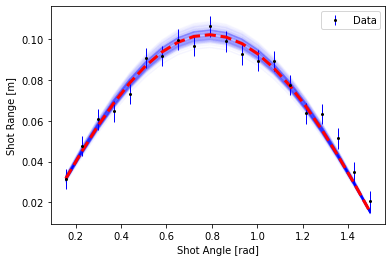

In [236]:
# Plot of the ensemble of optimal range curves over the data+error

plt.figure(4)
plt.errorbar(alphaMeas, rObs, yerr=rErr, lw=0, elinewidth=1, ecolor='b', fmt='ko', markersize=2)
plt.legend(['Data'])
for g in gAcceptMCMC[:200]:
    plt.plot(alphaMeas, modelFit(alphaMeas, g),'-b', alpha=0.02)

plt.plot(alphaMeas, modelFit(alphaMeas, *gOp),'r--', lw=3)
plt.xlabel('Shot Angle [rad]')
plt.ylabel('Shot Range [m]');

The mean value of the g ensemble using MCMC is: = 9.78069
The optimal g found with fitting was: = 9.77626
The % difference is : = 0.00499%


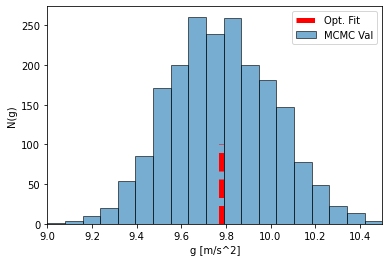

In [237]:
#%% Plot the histogram of accept 'g' values from the MCMC code
plt.figure(5)
plt.hist(gAcceptMCMC_flat, bins=np.linspace(9.0,10.5,20), edgecolor='k', alpha=0.6)
plt.plot(gOp[0]*np.ones(10), np.linspace(0,100,10),'--r', lw=5);
plt.xlim([9.0,10.5])
plt.ylabel('N(g)')
plt.xlabel('g [m/s^2]')
plt.legend(['Opt. Fit','MCMC Val'])
print('The mean value of the g ensemble using MCMC is: = {0:.5f}'.format(np.mean(gAcceptMCMC_flat)))
print('The optimal g found with fitting was: = {0:.5f}'.format(gOp[0]))
print('The % difference is : = {0:.5f}%'.format(np.abs(100*(1.-np.median(gAcceptMCMC_flat)/gOp[0]))));


Uncertainty in g using MC+Opt = 0.14[m/s^2]
Uncertainty in g using MCMC = 0.23[m/s^2]


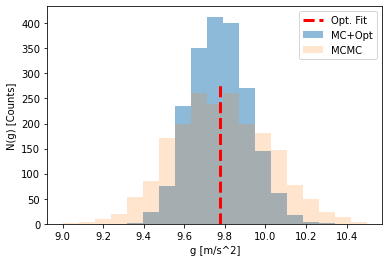

In [238]:
# Compare the two methods. Blue - MC+Optimization, Brown - MCMC. The bin size for each distribution is the same.

plt.figure(6)
bins=np.linspace(9.0,10.5,20)
plt.plot(gOp[0]*np.ones(10), np.linspace(0,280,10),'--r', lw=3)
plt.hist(gAcceptMC, bins=np.linspace(9.0,10.5,20), alpha=0.5)
#plt.hist(gAcceptMCMC, bins=np.linspace(gBounds[0],gBounds[1],20), alpha=0.2)
plt.hist(gAcceptMCMC_flat, bins=np.linspace(9.0,10.5,20), alpha=0.2)
plt.xlabel('g [m/s^2]')
plt.ylabel('N(g) [Counts]')
plt.legend(['Opt. Fit', 'MC+Opt','MCMC'])
print('Uncertainty in g using MC+Opt = {0:.2f}[m/s^2]'.format(np.std(gAcceptMC)))
print('Uncertainty in g using MCMC = {0:.2f}[m/s^2]'.format(np.std(gAcceptMCMC)))

The comparison between the two shows that the MCMC prediction for the spread in the distribution for 'g', i.e. the uncertainty is larger. Why? 

1). Did we sample enough? Perhaps the burn-in was not sufficent?

2). Starting value of 'g' was very far from the true value? 

3). The sampling domain for 'g' was to broad? --> This will come up when discussing Bayesian Priors. 